<a href="https://colab.research.google.com/github/SihanWu123/HW3/blob/main/OPTI556HW2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Consider the demosiacing neural network described in Table 3.1. Train the network as described in the text. Try to find an app for your smart phone that allows recording of raw format images. If you are unable to do this, find some raw format images online. Try to demosaic these images using the neural network, compare your results with the phone's built in demosaicing algorithm. Try improving the network of table 3.1 by adding more layers or more convolutions per layer, train the network and compare results. Compare the neural demosaicing algorithm with demosiacing built into openCV, as in the text or with other demosaicing algorithms. The main point of this exercise is to gain experience training and using neural networks, so be sure to try several different variations on the network and trainng strategy. Discuss your experience training the network in your report.

Using another raw image from camera to test the network

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from scipy import interpolate as interp
from scipy.special import expit
from google.colab import files
import imageio
from PIL import Image
import cv2
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
tf.experimental_relax_shapes=True

In [3]:
!pip install visualkeras
import visualkeras

In [4]:
!wget --no-check-certificate -r -nH --cut-dirs=2 --no-parent --reject="index.html*" https://www.math.purdue.edu/~lucier/PHOTO_CD/D65_TIFF_IMAGES/

--2021-12-02 22:16:11--  https://www.math.purdue.edu/~lucier/PHOTO_CD/D65_TIFF_IMAGES/
Resolving www.math.purdue.edu (www.math.purdue.edu)... 128.210.40.74
Connecting to www.math.purdue.edu (www.math.purdue.edu)|128.210.40.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5974 (5.8K) [text/html]
Saving to: ‘D65_TIFF_IMAGES/index.html.tmp’

D65_TIFF_IMAGES/ind 100%[===================>]   5.83K  --.-KB/s    in 0s      

2021-12-02 22:16:12 (196 MB/s) - ‘D65_TIFF_IMAGES/index.html.tmp’ saved [5974/5974]

Loading robots.txt; please ignore errors.
--2021-12-02 22:16:12--  https://www.math.purdue.edu/robots.txt
Reusing existing connection to www.math.purdue.edu:443.
HTTP request sent, awaiting response... 404 Not Found
2021-12-02 22:16:12 ERROR 404: Not Found.

Removing D65_TIFF_IMAGES/index.html.tmp since it should be rejected.

--2021-12-02 22:16:12--  https://www.math.purdue.edu/~lucier/PHOTO_CD/D65_TIFF_IMAGES/?C=N;O=D
Reusing existing connection to www.math.p

In [5]:
im=np.zeros((24,2048,3072,3))
for pop in range(1,10):
  fileN="D65_TIFF_IMAGES/IMG000"+np.str(pop)+".tif"
  imm = Image.open(fileN)
  imm=np.array(imm)
  w,h,c =imm.shape
  if w>h:
    imm=imm.transpose(1,0,2)
  im[pop-1,:,:,:]=np.array(imm)/255.
for pop in range(10,25):
  fileN="D65_TIFF_IMAGES/IMG00"+np.str(pop)+".tif"
  imm = Image.open(fileN)
  imm=np.array(imm)
  w,h, c =imm.shape
  if w>h:
    imm=imm.transpose(1,0,2)
  im[pop-1,:,:,:]=np.array(imm)/255.

In [6]:
def bayerCFA(shape,dtype='none'):
    kernel = np.array([[[1,0,0],[0,0,0]],[[0,0,0],[0,0,0]]])
    kernel = np.stack((kernel,np.array([[[0,0,0],[0,1,0]],[[0,0,0],[0,0,0]]]),np.array([[[0,0,0],[0,0,0]],[[0,1,0],[0,0,0]]]),np.array([[[0,0,0],[0,0,0]],[[0,0,0],[0,0,1]]] )),axis=-1)
    return kernel
inputs = layers.Input(shape=(None,None,3))
cfa = layers.Conv2D(4, (2,2), (2,2), use_bias=False, input_shape=(32,32,3),kernel_initializer=bayerCFA)(inputs)
cfaSample=Model(inputs,cfa)

In [7]:
trainS=7680
testS=1536
xtrain=np.zeros((trainS,64,64,4))
ytrain=np.zeros((trainS,128,128,3))
xtest=np.zeros((testS,64,64,4))
ytest=np.zeros((testS,128,128,3))
for imc in range(20):
  for row in range(16):
    for column in range(24):
      ytrain[(imc*20*16+row*24+column),:,:,:]=im[imc,(row*128):((row+1)*128),(column*128):((column+1)*128):,:]
      xtrain[(imc*20*16+row*24+column),:,:,:]=cfaSample.predict(im[imc:(imc+1),(row*128):((row+1)*128),(column*128):((column+1)*128):,:])
for imc in range(4):
  for row in range(16):
    for column in range(24):
      ytest[(imc*20*16+row*24+column),:,:,:]=im[imc+20,(row*128):((row+1)*128),(column*128):((column+1)*128):,:]
      xtest[(imc*20*16+row*24+column),:,:,:]=cfaSample.predict(im[(imc+20):(imc+21),(row*128):((row+1)*128),(column*128):((column+1)*128):,:])
xtrain=np.reshape(xtrain, (len(xtrain), 64, 64, 4))
ytrain=np.reshape(ytrain, (len(ytrain), 128, 128, 3))
xtest=np.reshape(xtest, (len(xtest), 64, 64, 4))
ytest=np.reshape(ytest, (len(ytest), 128, 128, 3))
train_dataset = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
test_dataset = tf.data.Dataset.from_tensor_slices((xtest,ytest))
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [8]:
del im # save more memory in RAM


In [68]:
inputs = layers.Input(shape=(None,None,4))
print(inputs.shape)
# Encoder
x1 = layers.Conv2D(16, (2, 2), strides=2, activation="relu", padding="same")(inputs)
print(x1.shape)
x = layers.MaxPooling2D((2, 2))(x1)
print(x.shape)
x2 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
print(x2.shape)
x3 = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x2)
print(x3.shape)
x = layers.MaxPooling2D((2, 2))(x3)
print(x.shape)
x = layers.Conv2D(128, (3, 3),  activation="relu", padding="same")(x)
print(x.shape)
# Decoder
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
print(x.shape)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
print(x.shape)
x=layers.add([x,x2])
print(x.shape)
x = layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(x)
print(x.shape)
x=layers.add([x,x1])
print(x.shape)
x = layers.Conv2DTranspose(4, (3, 3), strides=2, activation="relu", padding="same")(x)
print(x.shape)
x=layers.add([x,inputs])
print(x.shape)
x = layers.Conv2DTranspose(3, (3, 3), strides=2, activation="relu", padding="same")(x)
print(x.shape)
x = layers.Conv2D(3, (3, 3), activation="linear", padding="same")(x)
print(x.shape)

# Autoencoder
demosaic = Model(inputs, x)
demosaic.compile(optimizer="adam", loss="mean_squared_error")
demosaic.summary()

(None, None, None, 4)
(None, None, None, 16)
(None, None, None, 16)
(None, None, None, 32)
(None, None, None, 64)
(None, None, None, 64)
(None, None, None, 128)
(None, None, None, 128)
(None, None, None, 32)
(None, None, None, 32)
(None, None, None, 16)
(None, None, None, 16)
(None, None, None, 4)
(None, None, None, 4)
(None, None, None, 3)
(None, None, None, 3)
Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, None, None,  0           []                               
                                 4)]                                                              
                                                                                                  
 conv2d_142 (Conv2D)            (None, None, None,   272         ['input_25[0][0]']               
                       

In [34]:
demosaic.fit(train_dataset,
    epochs=20,
    batch_size=32,
    shuffle=True,
    validation_data=test_dataset
)


Epoch 1/20
240/240 [==============================] - 125s 514ms/step - loss: 0.0206 - val_loss: 0.0066
Epoch 2/20
240/240 [==============================] - 124s 515ms/step - loss: 0.0033 - val_loss: 0.0039
Epoch 3/20
240/240 [==============================] - 124s 518ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 4/20
240/240 [==============================] - 124s 519ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 5/20
240/240 [==============================] - 123s 513ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 6/20
240/240 [==============================] - 125s 520ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 7/20
240/240 [==============================] - 125s 521ms/step - loss: 9.2399e-04 - val_loss: 0.0012
Epoch 8/20
240/240 [==============================] - 126s 526ms/step - loss: 8.5256e-04 - val_loss: 0.0011
Epoch 9/20
240/240 [==============================] - 132s 549ms/step - loss: 8.0383e-04 - val_loss: 0.0011
Epoch 10/20
240/240 [==============================]

(4, 128, 128, 3)


Text(0.5, 1.0, 'Result')

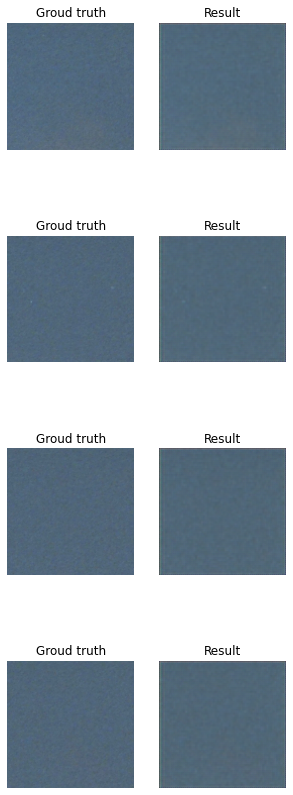

In [35]:
Res = demosaic.predict(xtest[0:4,:,:,:])
print(Res.shape)
plt.rcParams['figure.figsize'] = [5, 15]
plt.figure()

plt.subplot(4,2,1)
plt.imshow(ytest[0,:,:,:])
plt.axis('off')
plt.title("Groud truth")
plt.subplot(4,2,2)
plt.imshow(np.squeeze(Res[0:1,:,:,:]))
plt.axis('off')
plt.title("Result")
plt.subplot(4,2,3)
plt.imshow(ytest[1,:,:,:])
plt.axis('off')
plt.title("Groud truth")
plt.subplot(4,2,4)
plt.imshow(np.squeeze(Res[1:2,:,:,:]))
plt.axis('off')
plt.title("Result")
plt.subplot(4,2,5)
plt.imshow(ytest[2,:,:,:])
plt.axis('off')
plt.title("Groud truth")
plt.subplot(4,2,6)
plt.imshow(np.squeeze(Res[2:3,:,:,:]))
plt.axis('off')
plt.title("Result")
plt.subplot(4,2,7)
plt.imshow(ytest[3,:,:,:])
plt.axis('off')
plt.title("Groud truth")
plt.subplot(4,2,8)
plt.imshow(np.squeeze(Res[3:4,:,:,:]))
plt.axis('off')
plt.title("Result")

In [36]:
!pip install rawpy
import rawpy


In [9]:
!wget https://raw.githubusercontent.com/yuanyuansun-ua/opti556/main/Raw_C_0.tiff
I_raw = Image.open('Raw_C_0.tiff')
I_raw = np.array(I_raw)
I_raw = np.array(I_raw)
# I_rawImage=I_raw.raw_image_visible
I_rawImage = I_raw[0:2048,0:2048]
print(I_rawImage.shape)





!wget https://raw.githubusercontent.com/yuanyuansun-ua/opti556/main/C_0.tiff
I_cam = Image.open('C_0.tiff')
I_cam = np.array(I_cam)
I_cam = I_cam[0:2048,0:2048]
print(I_cam.shape)


--2021-12-02 22:29:55--  https://raw.githubusercontent.com/yuanyuansun-ua/opti556/main/Raw_C_0.tiff
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3671388 (3.5M) [image/tiff]
Saving to: ‘Raw_C_0.tiff.3’

Raw_C_0.tiff.3      100%[===================>]   3.50M  --.-KB/s    in 0.09s   

2021-12-02 22:29:57 (38.9 MB/s) - ‘Raw_C_0.tiff.3’ saved [3671388/3671388]

(2048, 2048)
--2021-12-02 22:29:58--  https://raw.githubusercontent.com/yuanyuansun-ua/opti556/main/C_0.tiff
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6878428 (6.6M) [a

In [37]:
I_raw_decomp = np.zeros((1024, 1024, 4))
I_raw_decomp[:,:,0] = I_rawImage[1:2048:2, 1:2048:2] #R
I_raw_decomp[:,:,1] = I_rawImage[1:2048:2, 0:2048:2] #G1
I_raw_decomp[:,:,2] = I_rawImage[0:2048:2, 1:2048:2] #G2
I_raw_decomp[:,:,3] = I_rawImage[0:2048:2, 0:2048:2] #B
print(I_raw_decomp.shape)

(1024, 1024, 4)


In [39]:
I_net = demosaic.predict(np.reshape(I_raw_decomp, [1, 1024, 1024, 4]))
I_net = np.squeeze(I_net)
print(I_net.shape)

(2048, 2048, 3)


In [40]:
  from skimage import color, data, restoration, exposure, metrics

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  """
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '$I_{opencv}$ MSE: 1.846, SSIM: 0.989')

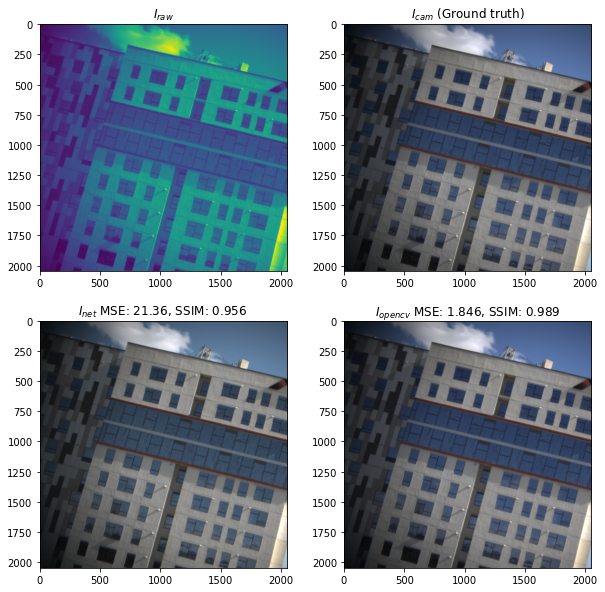

In [41]:
I_opencv = cv2.cvtColor(I_rawImage, cv2.COLOR_BayerRG2RGB)

MSE_net = metrics.mean_squared_error(I_cam, I_net)
MSE_cv = metrics.mean_squared_error(I_cam, I_opencv)
SSIM_net = metrics.structural_similarity(I_cam[:,:,1], I_net[:,:,1])
SSIM_cv = metrics.structural_similarity(I_cam[:,:,1], I_opencv[:,:,1])

plt.rcParams['figure.figsize'] = [10, 10]
plt.figure()
plt.subplot(2,2,1)
plt.imshow(I_rawImage)
plt.title("$I_{raw}$")
plt.subplot(2,2,2)
plt.imshow(I_cam)
plt.title("$I_{cam}$ (Ground truth)")
plt.subplot(2,2,3)
plt.imshow(I_net/255)
plt.title("$I_{net}$ MSE: "+np.str(MSE_net)[0:5]+", SSIM: "+np.str(SSIM_net)[0:5])
plt.subplot(2,2,4)
plt.imshow(I_opencv/255)
plt.title("$I_{opencv}$ MSE: "+np.str(MSE_cv)[0:5]+", SSIM: "+np.str(SSIM_cv)[0:5])



In [135]:
inputs = layers.Input(shape=(None,None,4))
# Encoder
x1 = layers.Conv2D(16, (2, 2), strides=2, activation='relu', padding="same")(inputs)
x = layers.MaxPooling2D((2, 2))(x1)
print(x1.shape)
print(x1.shape)
x = layers.Conv2D(16, (2, 2), strides=2, activation='relu', padding="same")(x1)
print(x.shape)
x = layers.MaxPooling2D((2, 2))(x)
print(x1.shape)
x2 = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(x)
print(x2.shape)
x3 = layers.Conv2D(64, (3, 3), strides=2, activation='relu', padding="same")(x2)
print(x3.shape)
x = layers.MaxPooling2D((2, 2))(x3)
print(x.shape)
x = layers.Conv2D(64, (3, 3), strides=2, activation='relu', padding="same")(x3)
print(x.shape)
x = layers.Conv2D(128, (3, 3),  activation='relu', padding="same")(x)
print(x.shape)
# Decoder
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding="same")(x)
print(x.shape)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding="same")(x)
print(x.shape)
# x=layers.add([x,x3])
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding="same")(x)
# x=layers.add([x,x2])
print(x.shape)
x = layers.Conv2DTranspose(16, (3, 3), strides=2, activation='relu', padding="same")(x)
x=layers.add([x,x1])
print(x.shape)
x = layers.Conv2DTranspose(4, (3, 3), strides=2, activation='relu', padding="same")(x)
print(x.shape)
x=layers.add([x,inputs])
x = layers.Conv2DTranspose(3, (3, 3), strides=2, activation="relu", padding="same")(x)
print(x.shape)
x = layers.Conv2D(3, (3, 3), activation="linear", padding="same")(x)

# Autoencoder
demosaic = Model(inputs, x)
demosaic.compile(optimizer="adam", loss="mean_squared_error")
demosaic.summary()

(None, None, None, 16)
(None, None, None, 16)
(None, None, None, 16)
(None, None, None, 16)
(None, None, None, 32)
(None, None, None, 64)
(None, None, None, 64)
(None, None, None, 64)
(None, None, None, 128)
(None, None, None, 128)
(None, None, None, 64)
(None, None, None, 32)
(None, None, None, 16)
(None, None, None, 4)
(None, None, None, 3)
Model: "model_45"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_59 (InputLayer)          [(None, None, None,  0           []                               
                                 4)]                                                              
                                                                                                  
 conv2d_390 (Conv2D)            (None, None, None,   272         ['input_59[0][0]']               
                                16)        

In [136]:
demosaic.fit(train_dataset,
    epochs=20,
    batch_size=32,
    shuffle=True,
    validation_data=test_dataset
)

Epoch 1/20
240/240 [==============================] - 90s 369ms/step - loss: 0.0125 - val_loss: 0.0051
Epoch 2/20
240/240 [==============================] - 84s 352ms/step - loss: 0.0035 - val_loss: 0.0045
Epoch 3/20
240/240 [==============================] - 86s 360ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 4/20
240/240 [==============================] - 85s 355ms/step - loss: 0.0026 - val_loss: 0.0036
Epoch 5/20
240/240 [==============================] - 86s 356ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 6/20
240/240 [==============================] - 85s 352ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 7/20
240/240 [==============================] - 85s 352ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 8/20
240/240 [==============================] - 85s 354ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 9/20
240/240 [==============================] - 84s 352ms/step - loss: 8.2928e-04 - val_loss: 0.0016
Epoch 10/20
240/240 [==============================] - 85s 355ms/step

In [137]:
I_net = demosaic.predict(np.reshape(I_raw_decomp, [1, 1024, 1024, 4]))
I_net = np.squeeze(I_net)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '$I_{opencv}$ MSE: 1.846, SSIM: 0.989')

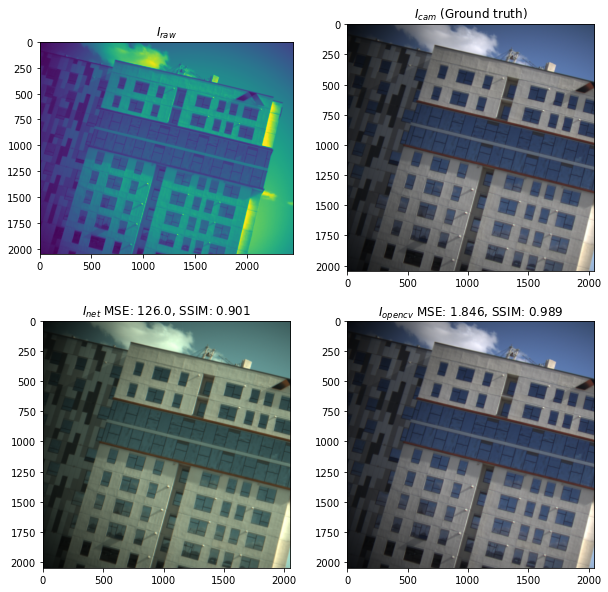

In [138]:
I_opencv = cv2.cvtColor(I_rawImage, cv2.COLOR_BayerRG2RGB)
# print(I_raw.shape)

MSE_net = metrics.mean_squared_error(I_cam, I_net)
MSE_cv = metrics.mean_squared_error(I_cam, I_opencv)
SSIM_net = metrics.structural_similarity(I_cam[:,:,1], I_net[:,:,1])
SSIM_cv = metrics.structural_similarity(I_cam[:,:,1], I_opencv[:,:,1])

plt.rcParams['figure.figsize'] = [10, 10]
plt.figure()
plt.subplot(2,2,1)
plt.imshow(I_raw)
plt.title("$I_{raw}$")
plt.subplot(2,2,2)
plt.imshow(I_cam)
plt.title("$I_{cam}$ (Ground truth)")
plt.subplot(2,2,3)
plt.imshow(I_net/255)
plt.title("$I_{net}$ MSE: "+np.str(MSE_net)[0:5]+", SSIM: "+np.str(SSIM_net)[0:5])
plt.subplot(2,2,4)
plt.imshow(I_opencv)
plt.title("$I_{opencv}$ MSE: "+np.str(MSE_cv)[0:5]+", SSIM: "+np.str(SSIM_cv)[0:5])

